# Tracking a Panda in a Bamboo Grove: Exponential Smoothing vs. Running Mean

#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025  

\
The simulation of a panda's stepwise random walk, noisy measurement generation, noise variance identification using residuals, calculation of optimal exponential smoothing coefficient, smoothing, and visualization.

## Part 1. Calm walk

### 1-2. Generate the panda's true trajectory. Generate noisy measurements
Simulate the true position trajectory $X_i$ using the random walk model:

$X_i = X_{i-1} + w_i$, where $w_i \sim \mathcal{N}(0, \sigma_w^2)$ -- normally distributed noise.

$z_i = X_i + \eta_i$, where $\eta_i \sim \mathcal{N}(0, \sigma_\eta^2)$ with .

Parameters:
- $\sigma_w^2 = 12$
- $\sigma_\eta^2 = 9$
- Initial position $X_1 = 10$ m

In [579]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_random_walk(n_points, sigma_w_sq, sigma_eta_sq, init_pos=10, fig_num=None, title=None):
    wi = np.random.normal(0, np.sqrt(sigma_w_sq), n_points)
    Xi = np.zeros(n_points)
    Xi[0] = init_pos
    for i in range(1, n_points):
        Xi[i] = Xi[i-1] + wi[i]
    eta = np.random.normal(0, np.sqrt(sigma_eta_sq), n_points)
    z = Xi + eta

    if fig_num:
        plt.figure(figsize=(8,5))
        plt.plot(Xi, label='True Trajectory', linewidth=1)
        plt.plot(z, label='Noisy Measurements', alpha=0.6, linewidth=1)
        plt.xlabel('Step')
        plt.ylabel('Position (m)')
        plt.title(f'Panda Trajectory (n = {n_points})')
        if title:
            plt.suptitle(f'{title}', fontsize=16, y=0.005)
        else:
            plt.suptitle(f'Figure {fig_num}: Simulated panda trajectory and noisy measurements (n = {n_points})', fontsize=16, y=0.005)
        plt.legend()
        plt.grid()
        plt.show()

    return Xi, z, wi, eta

sigma_w_sq = 12
sigma_eta_sq = 9
init_pos = 10

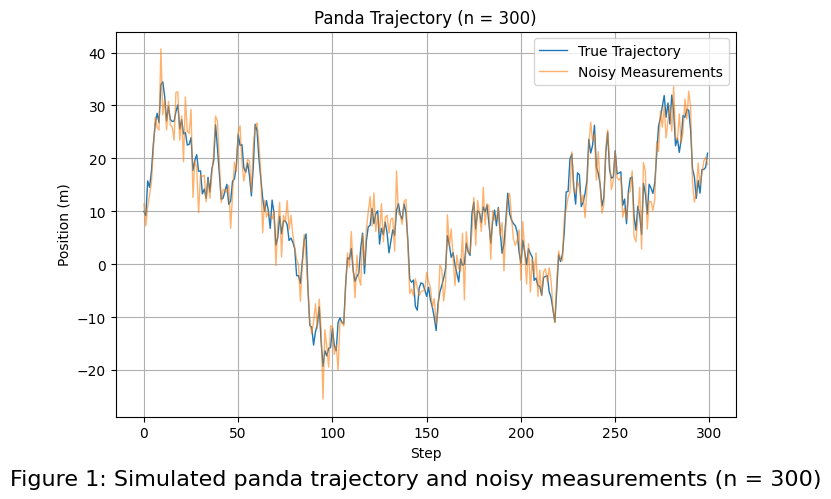

In [580]:
res_300  = simulate_random_walk(n_points=300 , sigma_w_sq=sigma_w_sq, sigma_eta_sq=sigma_eta_sq, init_pos=init_pos, fig_num=1)

Fig 1 represents a random walk for 300-time steps which show the movement of panda in a bamboo grove. Addition of the noise measurements is depicted by the fluctuations around the true trajectory. The overall trend of movement is quite clear showing the irregularities leading to a less smooth estimated path. 


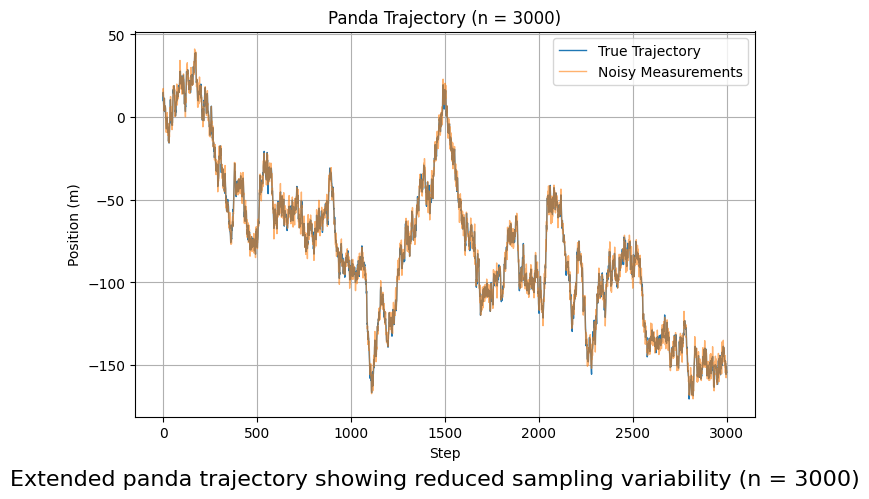

In [581]:
res_3000 = simulate_random_walk(n_points=3000, sigma_w_sq=sigma_w_sq, sigma_eta_sq=sigma_eta_sq, init_pos=init_pos, fig_num=2, title="Extended panda trajectory showing reduced sampling variability (n = 3000)")

Fig 2 represents panda’s long-term movement up to 3000 steps; the larger dataset allows overall trend to become clearer even in the presence of noise. There is a close alignment between true and measured path which indicate the impact of noise is small as compared to total displacement. 

### 3. Identify process and measurement noise variances

#### The system:
- $E[v^2]$ = $\sigma_w^2$ + $2*\sigma_\eta^2$
- $E[p^2]$ = $2 * \sigma_w^2$ + $2*\sigma_\eta^2$

In [582]:
def identify_noise_variances(wi, eta):
    v = wi[1:] + eta[1:] - eta[:-1]
    E_v2 = np.mean(v**2)

    p = wi[2:] + wi[1:-1] + eta[2:] - eta[:-2]
    E_p2 = np.mean(p**2)

    A = np.array([[1, 2], [2, 2]])
    b = np.array([E_v2, E_p2])
    sigma_w_sq_est, sigma_eta_sq_est = np.linalg.solve(A, b)
    return sigma_w_sq_est, sigma_eta_sq_est

#### Results for n points = 300

In [583]:
X_1, z_1, wi_1, eta_1 = res_300
sigma_w_est_1, sigma_eta_est_1 = identify_noise_variances(wi_1, eta_1)
print(f"Estimated sigma_w^2: {sigma_w_est_1:.2f} (true {sigma_w_sq})")
print(f"Estimated sigma_eta^2: {sigma_eta_est_1:.2f} (true {sigma_eta_sq})")

Estimated sigma_w^2: 8.78 (true 12)
Estimated sigma_eta^2: 12.40 (true 9)


#### Results for n points = 3000

In [584]:
X_2, z_2, wi_2, eta_2 = res_3000
sigma_w_est_2, sigma_eta_est_2 = identify_noise_variances(wi_2, eta_2)
print(f"Estimated sigma_w^2: {sigma_w_est_2:.2f} (true {sigma_w_sq})")
print(f"Estimated sigma_eta^2: {sigma_eta_est_2:.2f} (true {sigma_eta_sq})")

Estimated sigma_w^2: 11.72 (true 12)
Estimated sigma_eta^2: 8.50 (true 9)


We can see that for a large data set (3000 points) the estimated values for both sigma_w and sigma_eta are more accurate in comparison to 300 points .That suggests that with enough data points the estimation can be more accurate.

### 4. Calculate optimal smoothing coefficient
Calculate exponential smoothing coefficient $\alpha$ with:

$\alpha = \frac{-\chi + \sqrt{\chi^2 + 4\chi}}{2}, \quad \chi = \frac{\sigma_w^2}{\sigma_\eta^2}$

In [585]:
def calc_optimal_alpha(sigma_w_sq, sigma_eta_sq):
    chi = sigma_w_sq / sigma_eta_sq
    alpha = (-chi + np.sqrt(chi**2 + 4*chi)) / 2
    return alpha

#### Smoothing coefficient for n points = 300

In [586]:
alpha_1 = calc_optimal_alpha(sigma_w_est_1, sigma_eta_est_1)

print(f"Optimal smoothing coefficient: {alpha_1:.3f}")

Optimal smoothing coefficient: 0.559


#### Smoothing coefficient for n points = 3000

In [587]:
alpha_2 = calc_optimal_alpha(sigma_w_est_2, sigma_eta_est_2)

print(f"Optimal smoothing coefficient: {alpha_2:.3f}")

Optimal smoothing coefficient: 0.672


### 5. Exponential smoothing
Smooth measurements $z$ using exponential smoothing with coefficient $\alpha$:

$z_i = \alpha z_i + (1-\alpha) z_{i-1}$

In [588]:
def exponential_smoothing(z, alpha):
    s = np.zeros_like(z)
    s[0] = z[0]
    for i in range(1, len(z)):
        s[i] = alpha * z[i] + (1 - alpha) * s[i-1]
    return s


#### Exponential smoothing results for n = 300

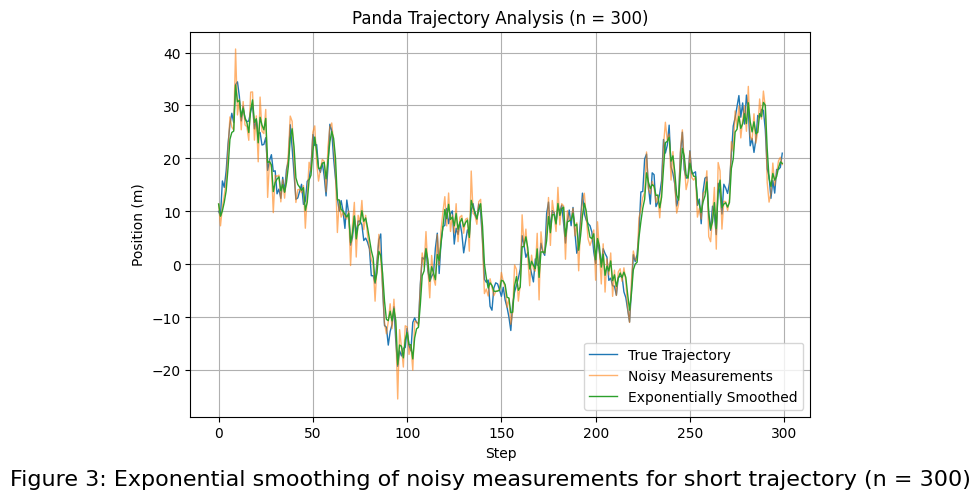

In [589]:
smoothed_1 = exponential_smoothing(z_1, alpha_1)

plt.figure(figsize=(8,5))
plt.plot(X_1, label='True Trajectory', linewidth=1)
plt.plot(z_1, label='Noisy Measurements', alpha=0.6, linewidth=1)
plt.plot(smoothed_1, label='Exponentially Smoothed', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title(f'Panda Trajectory Analysis (n = {300})')
plt.suptitle(f'Figure 3: Exponential smoothing of noisy measurements for short trajectory (n = {300})', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

Fig 3 depicts the effect of exponential smoothing which reduces the short-term noise by minimizing the random fluctuations in measurements and maintaining the natural variations.

#### Exponential smoothing results for n = 3000

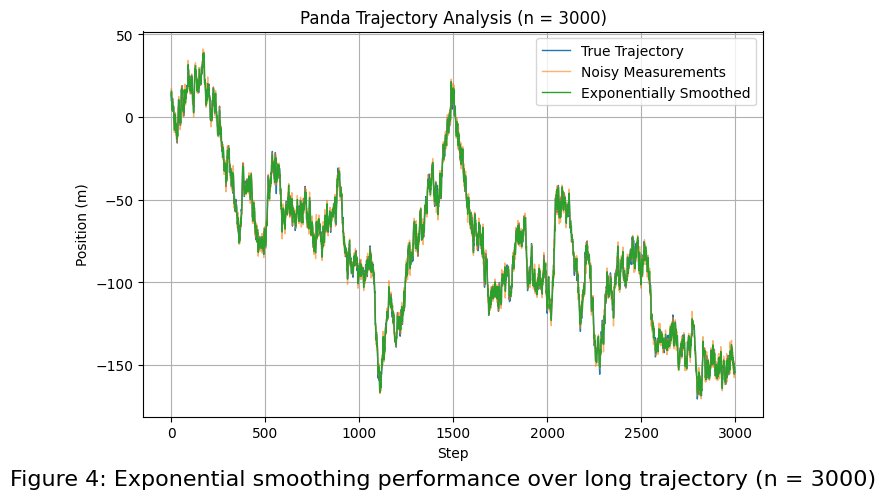

In [590]:
smoothed_2 = exponential_smoothing(z_2, alpha_2)

plt.figure(figsize=(8,5))
plt.plot(X_2, label='True Trajectory', linewidth=1)
plt.plot(z_2, label='Noisy Measurements', alpha=0.6, linewidth=1)
plt.plot(smoothed_2, label='Exponentially Smoothed', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title(f'Panda Trajectory Analysis (n = {3000})')
plt.suptitle(f'Figure 4: Exponential smoothing performance over long trajectory (n = {3000})', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

By Fig 4, it is clear that with longer sequence the exponential smoothing preserves the overall drift ensuring the stability of the trajectory. 

## Part 2 – Shaky Cameras: Testing Under Harsh Conditions

Simulate panda movement with increased process noise and measurement noise to represent harsh conditions

### 1-2. Generate true trajectory with higher noise. Generate noisy measurements

Parameters:
- $\sigma_w^2 = 28^2$
- $\sigma_\eta^2 = 97^2$
- Initial position $X_1 = 10$ m

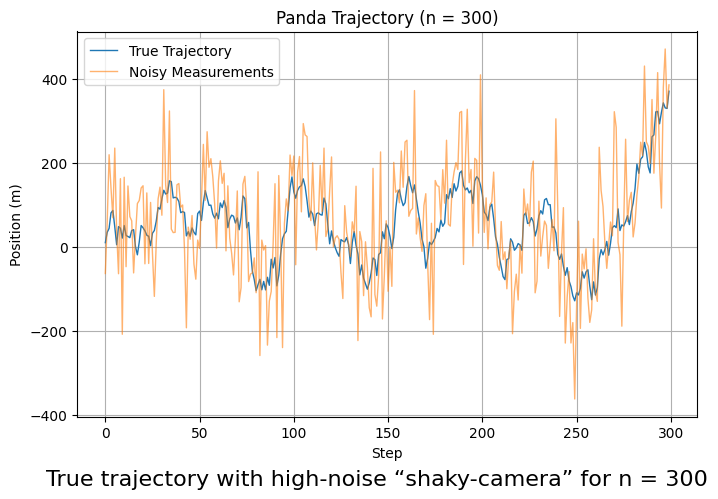

In [591]:
sigma_w2_shaky = 28**2
sigma_eta2_shaky = 97**2
init_pos = 10

res_shaky = simulate_random_walk(n_points=300 , sigma_w_sq=sigma_w2_shaky, sigma_eta_sq=sigma_eta2_shaky, init_pos=init_pos, fig_num=5, title="True trajectory with high-noise “shaky-camera” for n = 300")

## 3. Determine optimal smoothing coefficient
Use given noise variances and formula from Part I.

In [592]:
alpha_shaky = calc_optimal_alpha(sigma_w2_shaky, sigma_eta2_shaky)
print(f"Optimal smoothing coefficient alpha: {alpha_shaky:.4f}")

Optimal smoothing coefficient alpha: 0.2500


## 4. Find running mean window size M to equalize measurement-error contributions
$\sigma_{RM}^2 = \frac{\sigma_\eta^2}{M}$  
$\sigma_{ES}^2 = \frac{\sigma_\eta^2 \alpha}{2 - \alpha}$.  
Solve for $M$: 
$M = \frac{2 - \alpha}{\alpha}$

In [593]:
M = round((2 - alpha_shaky) / alpha_shaky)
print(f"Running mean window size M: {M}")

Running mean window size M: 7


## 5. Apply running mean and exponential smoothing on shaky measurements

In [594]:
def running_mean(data, window_size):
    if len(data) < window_size:
        return []

    N = len(data)
    smoothed = np.zeros(N)

    for i in range(N):
        smoothed[i] = np.mean(data[max(0, i - (window_size - 1) // 2):min(N, i + (window_size - 1) // 2)])

    return smoothed

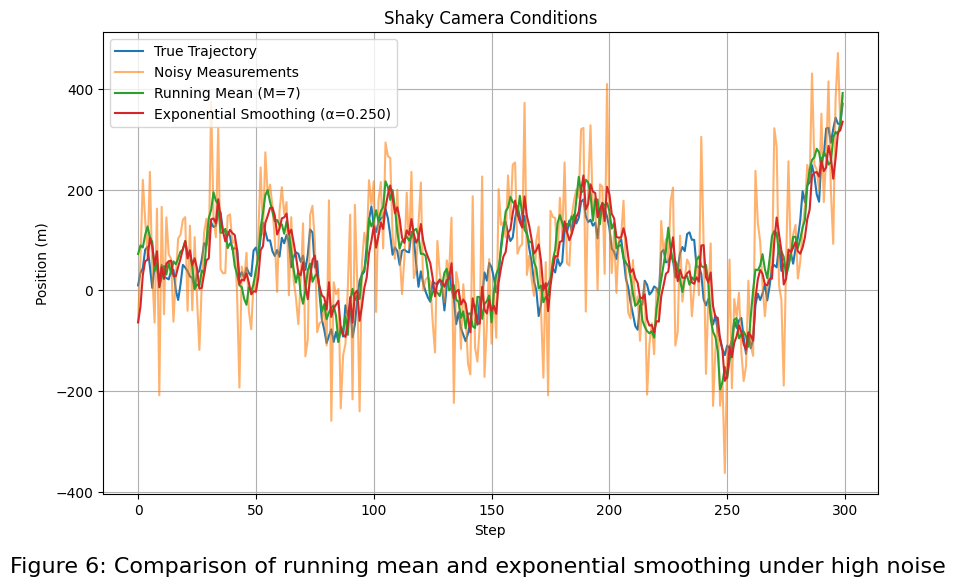

In [598]:
Xi, z, _, _ = res_shaky
es_smoothed = exponential_smoothing(z, alpha_shaky)
rm_smoothed = running_mean(z, M)

plt.figure(figsize=(10,6))
plt.plot(Xi, label='True Trajectory')
plt.plot(z, label='Noisy Measurements', alpha=0.6)
plt.plot(rm_smoothed, label=f'Running Mean (M={M})')
plt.plot(es_smoothed, label=f'Exponential Smoothing (α={alpha_shaky:.3f})')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('Shaky Camera Conditions')
plt.suptitle(f'Figure 6: Comparison of running mean and exponential smoothing under high noise', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

Fig 6 shows the comparison of exponential smoothing and running mean involving the true trajectory and noisy measurements. 

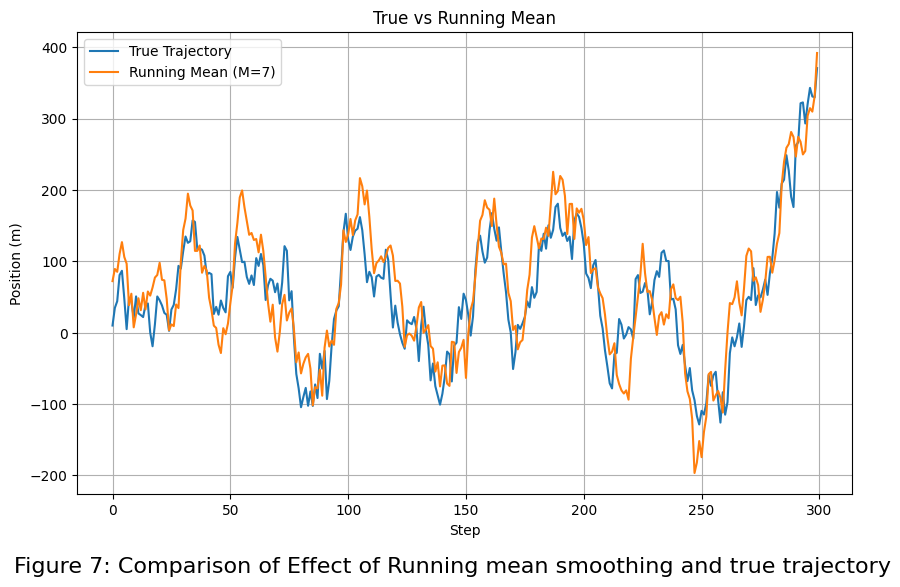

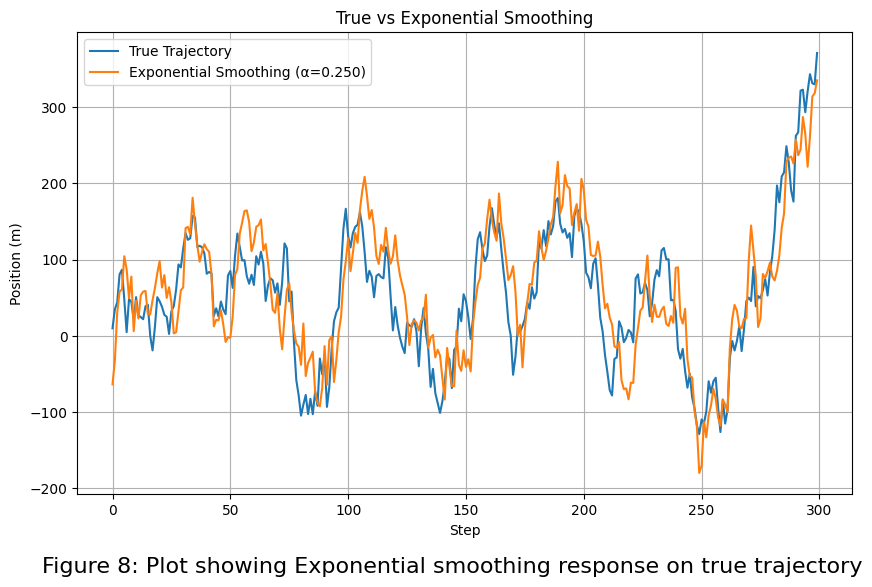

In [599]:
plt.figure(figsize=(10,6))
plt.plot(Xi, label='True Trajectory')
plt.plot(rm_smoothed, label=f'Running Mean (M={M})')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('True vs Running Mean')
plt.suptitle(f'Figure 7: Comparison of Effect of Running mean smoothing and true trajectory', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(Xi, label='True Trajectory')
plt.plot(es_smoothed, label=f'Exponential Smoothing (α={alpha_shaky:.3f})')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('True vs Exponential Smoothing')
plt.suptitle(f'Figure 8: Plot showing Exponential smoothing response on true trajectory', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

It can be seen that both methods show a similar estimation. However, from the figure 8 it can be seen that exponential smoothing involves a lag in estimations which is related to the weight of the last measurement in the prediction.

## 6. Visual errors comparison

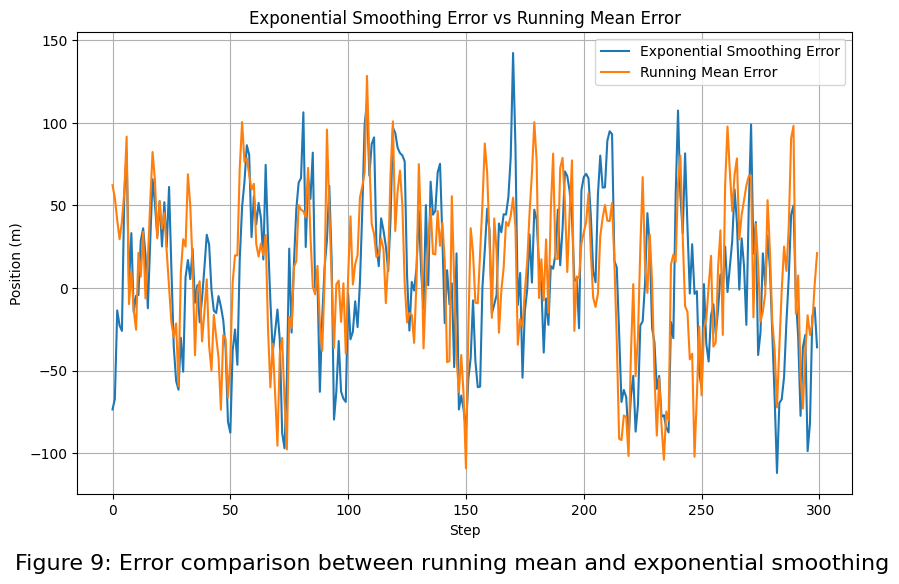

In [596]:
plt.figure(figsize=(10,6))
plt.plot(es_smoothed - Xi, label='Exponential Smoothing Error')
plt.plot(rm_smoothed - Xi, label=f'Running Mean Error')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('Exponential Smoothing Error vs Running Mean Error')
plt.suptitle("Figure 9: Error comparison between running mean and exponential smoothing", fontsize=16, y=0.01)
plt.legend()
plt.grid()
plt.show()

Figure 9 confirms the similar behaviour of the presented analysis methods from the errors perspective, but exponential smoothing loss accuracy due to existing lag.

In [597]:
rmse_es = np.sqrt(np.sum((es_smoothed - Xi)**2) / (len(Xi) - 1))
rmse_rm = np.sqrt(np.sum((rm_smoothed - Xi)**2) / (len(Xi) - 1))

print(f"RMSE for exponential smoothing: {rmse_es:.4f}")
print(f"RMSE for running mean: {rmse_rm:.4f}")

RMSE for exponential smoothing: 49.3181
RMSE for running mean: 46.9351


## Learning Log
1. In general, the running mean produced a lower RMSE than exponential smoothing, showing it was more effective in reducing measurement noise.
2. While the exponential smoothing efficiently filtered noise, it introduced a noticeable lag when tracking rapid changes in the trajectory.
3. Exponential smoothing, though less accurate in RMSE, responded faster to variations due to its adaptive weighting of recent measurements.
4. The results highlight the importance of selecting an optimal smoothing coefficient (α) to balance responsiveness and stability; overall, the RMSE comparison shows that the running mean provides better noise filtering, whereas exponential smoothing offers quicker adaptation to dynamic changes.